<a href="https://colab.research.google.com/github/OscarLoOscar/FSSE2309-Project/blob/main/GPT_4o_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install selenium
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
import shlex
import pandas as pd
import datetime
from bs4 import BeautifulSoup
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from google.colab import drive
import numpy as np
import tensorflow as tf
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
import re
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
import keras_tuner as kt

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# **拎Big Data**



In [ ]:
class HKJCWebScraper:
    def __init__(self):
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_argument("--disable-gpu")
        chrome_options.add_argument("--remote-debugging-port=9222")
        self.browser = webdriver.Chrome(options=chrome_options)
        self.base_url = 'https://racing.hkjc.com/racing/information/Chinese/Racing/LocalResults.aspx?RaceDate='

    def get_dates(self):
        self.browser.get(self.base_url + '2024/05/29')  # Example date to access the page
        try:
            # Wait for the select element to be present
            select_element = WebDriverWait(self.browser, 20).until(
                EC.presence_of_element_located((By.ID, "selectId"))
            )
            options = WebDriverWait(self.browser, 20).until(
                EC.presence_of_all_elements_located((By.TAG_NAME, "option"))
            )
            dates = [option.get_attribute("value") for option in options]
            return dates
        except Exception as e:
            print(f"An error occurred while fetching dates: {e}")
            return []

        # Extract data from performance table
        performance_data = []
        performance_table = soup.find('table', class_='f_tac table_bd draggable')
        if performance_table:
            rows = performance_table.find_all('tr')
            for row in rows:
                performance_data.append([cell.get_text(strip=True) for cell in row.find_all('td')])

       # Extract data from dividend_tab
        dividend_data = []
        dividend_table = soup.find('table', class_='table_bd f_tac f_fs13 f_fl')
        if dividend_table:
            rows = dividend_table.find_all('tr')
            for row in rows:
                dividend_data.append([cell.get_text(strip=True) for cell in row.find_all('td')])

        return race_tab_data, performance_data, dividend_data
       # return race_tab_data, performance_data

    def close(self):
        self.browser.quit()

scraper = HKJCWebScraper()


In [ ]:
all_data = []
dates = scraper.get_dates()
for date in dates:
    print(f"Scraping data for {date}")
    try:
        data = scraper.scrape_data_for_date(date)
        all_data.append({date: data})
    except Exception as e:
        print(f"Failed to scrape data for {date}: {e}")

# file_path = '/content/drive/My Drive/horse_data2.xlsx'
# all_data.to_excel(file_path, index=False)
def parse_data(all_data):
    data_list = []
    for race in all_data:
        for date, (meta, race_results) in race.items():
            if not race_results:  # 檢查 race_results 是否為空
                print(f"No race results for {date}")
                continue

            columns = race_results[0]
            for result in race_results[1:]:
                if len(result) != len(columns):
                    print(f"Mismatch in columns and data for {date}: {result}")
                    continue

                race_dict = {col: val for col, val in zip(columns, result)}
                race_dict['date'] = date
                data_list.append(race_dict)

    return pd.DataFrame(data_list)

df = parse_data(all_data)

# 保存為Excel文件
file_path = '/content/drive/My Drive/horse_data.xlsx'
df.to_excel(file_path, index=False)



In [ ]:
import requests
# 定义目标 URL
base_url = "https://racing.hkjc.com/racing/information/Chinese/Racing/LocalResults.aspx?RaceDate="

def get_dates():
    response = requests.get(base_url + '2024/05/29')
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.text, 'html.parser')
    select_element = soup.find('select', {'id': 'selectId'})
    options = select_element.find_all('option')
    dates = [option.get('value') for option in options]
    return dates

def scrape_data_for_date(date):
    response = requests.get(base_url + date)
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.text, 'html.parser')

    # Check if the request was successful
    if response.status_code == 200:
        # Find and print the race date and location
        race_date_location = soup.find('p', class_='f_clear')
        if race_date_location:
            race_date_location_text = race_date_location.text.strip()
        else:
            race_date_location_text = "N/A"

        # Find and print the race class and distance
        race_class_distance = soup.find('td', style='width: 385px;')
        if race_class_distance:
            race_class_distance_text = race_class_distance.text.strip()
        else:
            race_class_distance_text = "N/A"

        # Find and print the field condition
        field_condition_label = soup.find('td', style='width: 110px;', string='場地狀況 :')
        if field_condition_label:
            field_condition = field_condition_label.find_next_sibling('td')
            if field_condition:
                field_condition_text = field_condition.text.strip()
            else:
                field_condition_text = "N/A"
        else:
            field_condition_text = "N/A"

        # Find and print the track type
        track_type_label = soup.find('td', string='賽道 :')
        if track_type_label:
            track_type = track_type_label.find_next_sibling('td')
            if track_type:
                track_type_text = track_type.text.strip()
            else:
                track_type_text = "N/A"
        else:
            track_type_text = "N/A"

        return {
            "賽事日期和地點": race_date_location_text,
            "賽事等級和距離": race_class_distance_text,
            "場地狀況": field_condition_text,
            "賽道": track_type_text
        }
    else:
        print(f"Failed to retrieve the website content for date: {date}")
        return None

all_data = []
dates = get_dates()
for date in dates:
    print(f"Scraping data for {date}")
    try:
        data = scrape_data_for_date(date)
        if data:
            all_data.append({date: data})
    except Exception as e:
        print(f"Failed to scrape data for {date}: {e}")

def parse_data(all_data):
    data_list = []
    for race in all_data:
        for date, race_results in race.items():
            race_results['date'] = date
            data_list.append(race_results)
    return pd.DataFrame(data_list)

df = parse_data(all_data)

# 保存为 Excel 文件
file_path = '/content/drive/My Drive/horse_data2.xlsx'
df.to_excel(file_path, index=False)

print(f"数据已保存至 {file_path}")


# **Merge and filtering Data**

In [12]:
# 讀取數據
file_path = '/content/drive/My Drive/horse_data2.xlsx'
df = pd.read_excel(file_path)

# 先過濾掉 NaN 或非字符串的值
df = df.dropna(subset=['賽事日期和地點'])
df['賽事日期和地點'] = df['賽事日期和地點'].astype(str)


# 只保留 '賽事日期和地點' 列中的 '跑馬地' 或 '沙田' 字符串
df['賽事日期和地點'] = df['賽事日期和地點'].apply(lambda x: '跑馬地' if '跑馬地' in x else '沙田' if '沙田' in x else None)

# Function to extract the integer before '米'
def extract_distance(text):
    match = re.search(r'(\d+)米', text)
    if match:
        return int(match.group(1))
    return None

# 只保留距離
df['距離'] = df['賽事等級和距離'].apply(extract_distance)


filtered_df = df.dropna()
filtered_file_path = '/content/drive/My Drive/horse_data_filtered.xlsx'
filtered_df.to_excel(filtered_file_path, index=False)

print(f"過濾後的數據已保存至 {filtered_file_path}")

過濾後的數據已保存至 /content/drive/My Drive/horse_data_filtered.xlsx


In [13]:
filtered_file_path = '/content/drive/My Drive/horse_data_filtered.xlsx'
horse_data_filtered = pd.read_excel(filtered_file_path)
# display(filtered_df)
filtered_file_path2 = '/content/drive/My Drive/racing_course_info.xlsx'
racing_course_info = pd.read_excel(filtered_file_path2)
# display(filtered_df2)
file_path = '/content/drive/My Drive/horse_data.xlsx'
horse_data = pd.read_excel(file_path)
# display(racing_course_info)

In [18]:
# Ensure the date columns are in the same format
horse_data_filtered['date'] = pd.to_datetime(horse_data_filtered['date'], dayfirst=True)
horse_data['date'] = pd.to_datetime(horse_data['date'], dayfirst=True)

# Correctly rename the column in horse_data_filtered if necessary
horse_data_filtered.rename(columns={'賽事日期和地點': '地點'}, inplace=True)

# Merge the two files based on the date
merged_data = pd.merge(horse_data, horse_data_filtered[['date', '地點', '場地狀況', '賽道','距離']], on='date', how='left')

# Save the merged data to a new Excel file
output_path = '/content/drive/My Drive/merged_horse_data.xlsx'
merged_data.to_excel(output_path, index=False)

In [49]:
file_path = '/content/drive/My Drive/merged_horse_data.xlsx'
merged_data = pd.read_excel(file_path)

display(merged_data.columns)

Index(['名次', '馬號', '馬名', '騎師', '練馬師', '實際負磅', '排位體重', '檔位', '頭馬距離', '沿途走位',
       '完成時間', '獨贏賠率', 'date', '地點', '場地狀況', '賽道', '距離'],
      dtype='object')

In [50]:
# Step 3: Filter the data based on '名次'
def clean_ranking(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and '平頭馬' in x:
        return int(x.replace('平頭馬', ''))
    try:
        return int(x)
    except ValueError:
        return np.nan

if '名次' in merged_data.columns:
    merged_data['名次'] = merged_data['名次'].apply(clean_ranking)
else:
    print("Column '名次' does not exist in the DataFrame.")

# Step 4: Select relevant columns and drop NaN values
relevant_columns = ['馬號', '騎師', '練馬師', '實際負磅', '排位體重', '檔位', '名次','完成時間', '獨贏賠率','地點', '場地狀況', '賽道','距離']
merged_data = merged_data[relevant_columns].dropna()

# Step 5: Filter out rows with non-numeric '檔位' values and convert to integers
merged_data = merged_data[merged_data['檔位'].apply(lambda x: str(x).isdigit())]
merged_data['檔位'] = merged_data['檔位'].astype(int)

# Step 6: Filter out strange draw values (e.g., negative values, or values beyond a realistic range)
merged_data = merged_data[(merged_data['檔位'] > 0) & (merged_data['檔位'] <= 20)]  # Assuming realistic range is 1 to 20

# Step 7: Encode categorical columns
label_encoder_jockey = LabelEncoder()
label_encoder_trainer = LabelEncoder()
label_encoder_location = LabelEncoder()
label_encoder_location_state = LabelEncoder()
label_encoder_road = LabelEncoder()

merged_data['騎師'] = label_encoder_jockey.fit_transform(merged_data['騎師'])
merged_data['練馬師'] = label_encoder_trainer.fit_transform(merged_data['練馬師'])
merged_data['地點'] = label_encoder_location.fit_transform(merged_data['地點'])
merged_data['場地狀況'] = label_encoder_location_state.fit_transform(merged_data['場地狀況'])
merged_data['賽道'] = label_encoder_road.fit_transform(merged_data['賽道'])

  # 類別特徵編碼
merged_data['地點'] = merged_data['地點'].astype('category').cat.codes
merged_data['場地狀況'] = merged_data['場地狀況'].astype('category').cat.codes
merged_data['賽道'] = merged_data['賽道'].astype('category').cat.codes

merged_data = pd.get_dummies(merged_data, columns=['騎師', '練馬師','地點', '場地狀況', '賽道'])

# Function to convert time format to seconds
def time_to_seconds(time_str):
    minutes, seconds = time_str.split(':')
    return int(minutes) * 60 + float(seconds)

# Apply the function to the '完成時間' column
merged_data['完成時間_秒'] = merged_data['完成時間'].apply(time_to_seconds)


# Ensure boolean columns are converted to int
for col in merged_data.select_dtypes(include=['bool']).columns:
    merged_data[col] = merged_data[col].astype(int)

# Step 8: Add a new column 'race_id' based on existing columns
merged_data['race_id'] = merged_data.index + 1

print(merged_data.columns) # Display the first few rows of the processed DataFrame

Index(['馬號', '實際負磅', '排位體重', '檔位', '名次', '完成時間', '獨贏賠率', '距離', '騎師_0', '騎師_1',
       '騎師_2', '騎師_3', '騎師_4', '騎師_5', '騎師_6', '騎師_7', '騎師_8', '騎師_9', '騎師_10',
       '騎師_11', '騎師_12', '騎師_13', '騎師_14', '騎師_15', '騎師_16', '騎師_17', '騎師_18',
       '騎師_19', '騎師_20', '騎師_21', '騎師_22', '騎師_23', '騎師_24', '騎師_25', '騎師_26',
       '騎師_27', '騎師_28', '騎師_29', '騎師_30', '騎師_31', '騎師_32', '騎師_33', '騎師_34',
       '騎師_35', '騎師_36', '騎師_37', '騎師_38', '騎師_39', '騎師_40', '騎師_41', '騎師_42',
       '騎師_43', '騎師_44', '練馬師_0', '練馬師_1', '練馬師_2', '練馬師_3', '練馬師_4', '練馬師_5',
       '練馬師_6', '練馬師_7', '練馬師_8', '練馬師_9', '練馬師_10', '練馬師_11', '練馬師_12',
       '練馬師_13', '練馬師_14', '練馬師_15', '練馬師_16', '練馬師_17', '練馬師_18', '練馬師_19',
       '練馬師_20', '練馬師_21', '練馬師_22', '練馬師_23', '地點_0', '地點_1', '場地狀況_0',
       '場地狀況_1', '場地狀況_2', '場地狀況_3', '場地狀況_4', '場地狀況_5', '賽道_0', '賽道_1',
       '賽道_2', '賽道_3', '賽道_4', '賽道_5', '賽道_6', '完成時間_秒', 'race_id'],
      dtype='object')


In [32]:
display(merged_data.columns)

Index(['馬號', '實際負磅', '排位體重', '檔位', '名次', '完成時間', '獨贏賠率', '距離', '騎師_0', '騎師_1',
       '騎師_2', '騎師_3', '騎師_4', '騎師_5', '騎師_6', '騎師_7', '騎師_8', '騎師_9', '騎師_10',
       '騎師_11', '騎師_12', '騎師_13', '騎師_14', '騎師_15', '騎師_16', '騎師_17', '騎師_18',
       '騎師_19', '騎師_20', '騎師_21', '騎師_22', '騎師_23', '騎師_24', '騎師_25', '騎師_26',
       '騎師_27', '騎師_28', '騎師_29', '騎師_30', '騎師_31', '騎師_32', '騎師_33', '騎師_34',
       '騎師_35', '騎師_36', '騎師_37', '騎師_38', '騎師_39', '騎師_40', '騎師_41', '騎師_42',
       '騎師_43', '騎師_44', '練馬師_0', '練馬師_1', '練馬師_2', '練馬師_3', '練馬師_4', '練馬師_5',
       '練馬師_6', '練馬師_7', '練馬師_8', '練馬師_9', '練馬師_10', '練馬師_11', '練馬師_12',
       '練馬師_13', '練馬師_14', '練馬師_15', '練馬師_16', '練馬師_17', '練馬師_18', '練馬師_19',
       '練馬師_20', '練馬師_21', '練馬師_22', '練馬師_23', '地點_0', '地點_1', '場地狀況_0',
       '場地狀況_1', '場地狀況_2', '場地狀況_3', '場地狀況_4', '場地狀況_5', '賽道_0', '賽道_1',
       '賽道_2', '賽道_3', '賽道_4', '賽道_5', '賽道_6', '完成時間_秒', 'race_id'],
      dtype='object')

In [68]:
# 特徵工程
def feature_engineering(df):
    merged_data['排位體重'] = pd.to_numeric(merged_data['排位體重'], errors='coerce')
    merged_data['實際負磅'] = pd.to_numeric(merged_data['實際負磅'], errors='coerce')

    # 新的特徵創建，例如馬匹的平均速度
    merged_data['average_speed'] = merged_data['距離'] / merged_data['完成時間_秒']
    merged_data['total_weight'] = merged_data['排位體重'] + merged_data['實際負磅']
    return merged_data

df = feature_engineering(merged_data)

# 處理缺失值
df = df.dropna()

# 定義特徵和目標
features = df[['average_speed','total_weight','名次','檔位','騎師_0', '騎師_1',
       '騎師_2', '騎師_3', '騎師_4', '騎師_5', '騎師_6', '騎師_7', '騎師_8', '騎師_9', '騎師_10',
       '騎師_11', '騎師_12', '騎師_13', '騎師_14', '騎師_15', '騎師_16', '騎師_17', '騎師_18',
       '騎師_19', '騎師_20', '騎師_21', '騎師_22', '騎師_23', '騎師_24', '騎師_25', '騎師_26',
       '騎師_27', '騎師_28', '騎師_29', '騎師_30', '騎師_31', '騎師_32', '騎師_33', '騎師_34',
       '騎師_35', '騎師_36', '騎師_37', '騎師_38', '騎師_39', '騎師_40', '騎師_41', '騎師_42',
       '騎師_43', '騎師_44', '練馬師_0', '練馬師_1', '練馬師_2', '練馬師_3', '練馬師_4', '練馬師_5',
       '練馬師_6', '練馬師_7', '練馬師_8', '練馬師_9', '練馬師_10', '練馬師_11', '練馬師_12',
       '練馬師_13', '練馬師_14', '練馬師_15', '練馬師_16', '練馬師_17', '練馬師_18', '練馬師_19',
       '練馬師_20', '練馬師_21', '練馬師_22', '練馬師_23', '地點_0', '地點_1', '場地狀況_0',
       '場地狀況_1', '場地狀況_2', '場地狀況_3', '場地狀況_4', '場地狀況_5', '賽道_0', '賽道_1',
       '賽道_2', '賽道_3', '賽道_4', '賽道_5', '賽道_6']]
target = df['名次']

# 特徵縮放
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 切分數據集
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# 定義回調函數（如早停）
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 建立神經網絡模型
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=1024, step=32), input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units_4', min_value=32, max_value=64, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='linear'))  # 使用線性激活進行迴歸

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1]))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Clean up the directory if there were previous runs
import shutil
import os

tuner_directory = 'my_dir/intro_to_kt'
if os.path.exists(tuner_directory):
    shutil.rmtree(tuner_directory)

# 使用 Keras Tuner 進行超參數調整
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(X_train, y_train, epochs=400, validation_split=0.2, callbacks=[early_stopping])

# 獲取最佳模型
best_model = tuner.get_best_models(num_models=1)[0]

# 訓練最佳模型
history = best_model.fit(X_train, y_train, epochs=400, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# 評估模型
loss, mae = best_model.evaluate(X_test, y_test)
print(f'Mean Absolute Error: {mae}')

Trial 10 Complete [00h 00m 10s]
val_loss: 1.6186171770095825

Best val_loss So Far: 0.4368288516998291
Total elapsed time: 00h 05m 01s
Epoch 1/400
38/38 [==============================] - 2s 18ms/step - loss: 2.5176 - mae: 1.1697 - val_loss: 1.2834 - val_mae: 0.9394
Epoch 2/400
38/38 [==============================] - 0s 13ms/step - loss: 2.7452 - mae: 1.2039 - val_loss: 2.9868 - val_mae: 1.3877
Epoch 3/400
38/38 [==============================] - 0s 13ms/step - loss: 2.4433 - mae: 1.1561 - val_loss: 1.6777 - val_mae: 1.0372
Epoch 4/400
38/38 [==============================] - 1s 14ms/step - loss: 2.2110 - mae: 1.0817 - val_loss: 1.1274 - val_mae: 0.8392
Epoch 5/400
38/38 [==============================] - 1s 13ms/step - loss: 2.1860 - mae: 1.0882 - val_loss: 1.0602 - val_mae: 0.8597
Epoch 6/400
38/38 [==============================] - 1s 13ms/step - loss: 2.5013 - mae: 1.1323 - val_loss: 2.1194 - val_mae: 1.1640
Epoch 7/400
38/38 [==============================] - 1s 14ms/step - loss:

# **Step 2: Define a Function to Predict Top 4 Horses**

In [71]:
def predict_top_4(model, scaler, label_encoder_jockey, label_encoder_trainer, input_data, known_jockeys, known_trainers):
    # 解析输入数据
    location_data = input_data[0]
    horse_data = input_data[1]

    # 创建 DataFrame
    horse_columns = ['馬號', '馬名', '檔位', '負磅', '騎師', '練馬師', '馬匹體重']
    horse_df = pd.DataFrame(horse_data, columns=horse_columns)

    # 添加地點、場地狀況、賽道信息
    horse_df['地點'] = location_data[0]
    horse_df['場地狀況'] = location_data[1]
    horse_df['賽道'] = location_data[2]
    horse_df['距離'] = location_data[3]

    # 保留 '馬號' 和 '馬名' 列
    horse_ids = horse_df['馬號']
    horse_names = horse_df['馬名']

    # 检查并更新 LabelEncoder 的标签
    new_jockeys = set(horse_df['騎師']) - set(known_jockeys)
    if new_jockeys:
        label_encoder_jockey.classes_ = np.append(label_encoder_jockey.classes_, list(new_jockeys))

    new_trainers = set(horse_df['練馬師']) - set(known_trainers)
    if new_trainers:
        label_encoder_trainer.classes_ = np.append(label_encoder_trainer.classes_, list(new_trainers))

    # 编码分类特征
    horse_df['騎師'] = label_encoder_jockey.transform(horse_df['騎師'])
    horse_df['練馬師'] = label_encoder_trainer.transform(horse_df['練馬師'])

    # 将分类特征转换为独热编码
    horse_df = pd.get_dummies(horse_df, columns=['騎師', '練馬師', '地點', '場地狀況', '賽道'])

    # 重新索引以匹配训练特征集，排除 '馬號' 和 '馬名'
    feature_columns = [col for col in features.columns if col not in ['馬號', '馬名']]
    horse_df = horse_df.reindex(columns=feature_columns, fill_value=0)

    # 归一化输入特征
    input_scaled = scaler.transform(horse_df)

    # 进行预测
    predictions = model.predict(input_scaled)
    horse_df['prediction'] = predictions

    # 添加回 '馬號' 和 '馬名' 列
    horse_df['馬號'] = horse_ids
    horse_df['馬名'] = horse_names

    # 获取预测概率最高的前4名马匹
    top_4_horses = horse_df.nlargest(6, 'prediction')
    return top_4_horses[['馬號', '馬名', 'prediction']]

#Input Data then Predict

In [72]:
input_data = [['跑馬地','好地','草地 - "A" 賽道',1000],
  [[1,'勁無敵', 5, 135,'蔡明紹','羅富全',1039],
    [2, '同滿滿', 10, 135,'霍宏聲','伍鵬志',1082],
    [3, '會展二號', 4, 134,'鍾易禮','告東尼',1145],
    [4, '威武勇駒', 7, 133,'布文','姚本輝',1089],
    [5,'中華威威',8,132,'黃智弘','徐雨石',1243],
    [6,'有你有我',12,130,'艾道拿','廖康銘',973],
    [7,'飛躍精英',3,129,'巴度','賀賢',1088],
    [8,'佳景臨門',1,128,'艾兆禮','葉楚航',1119],
    [9,'萬事有',6,124,'希威森','容天鵬',1242],
    [10,'友誼至佳',9,119,'董明朗','韋達',1182],
    [11,'月球',11,118,'湯普新','黎昭昇',1154],
    [12,'錢途光明',2,115,'潘明輝','丁冠豪',1068]]
]

known_jockeys = label_encoder_jockey.classes_
known_trainers = label_encoder_trainer.classes_
top_4_horses = predict_top_4(best_model, scaler, label_encoder_jockey, label_encoder_trainer, input_data, known_jockeys, known_trainers)
display(top_4_horses)

1/1 [==============================] - 0s 28ms/step


,馬號,馬名,prediction
4,5,中華威威,11.266543
8,9,萬事有,10.989826
1,2,同滿滿,10.772727
6,7,飛躍精英,10.737611
9,10,友誼至佳,10.591186
11,12,錢途光明,10.533784


In [ ]:
print(label_encoder_jockey.classes_)
print(label_encoder_trainer.classes_)
print(label_encoder_location.classes_)
print(label_encoder_location_state.classes_)
print(label_encoder_road.classes_)

Trial 10 Complete [00h 00m 15s]
val_loss: 2.2399280071258545

Best val_loss So Far: 1.0168248414993286
Total elapsed time: 00h 03m 32s
Epoch 1/200
38/38 [==============================] - 2s 16ms/step - loss: 4.6136 - mae: 1.4887 - val_loss: 5.3676 - val_mae: 1.8004
Epoch 2/200
38/38 [==============================] - 0s 10ms/step - loss: 5.6084 - mae: 1.6829 - val_loss: 2.5776 - val_mae: 1.2581
Epoch 3/200
38/38 [==============================] - 0s 9ms/step - loss: 5.0359 - mae: 1.6258 - val_loss: 5.9281 - val_mae: 1.9044
Epoch 4/200
38/38 [==============================] - 0s 9ms/step - loss: 3.8126 - mae: 1.4095 - val_loss: 0.7668 - val_mae: 0.6607
Epoch 5/200
38/38 [==============================] - 0s 10ms/step - loss: 3.2522 - mae: 1.2813 - val_loss: 3.0505 - val_mae: 1.3687
Epoch 6/200
38/38 [==============================] - 0s 9ms/step - loss: 4.2135 - mae: 1.4200 - val_loss: 0.6730 - val_mae: 0.6441
Epoch 7/200
38/38 [==============================] - 0s 10ms/step - loss: 3.

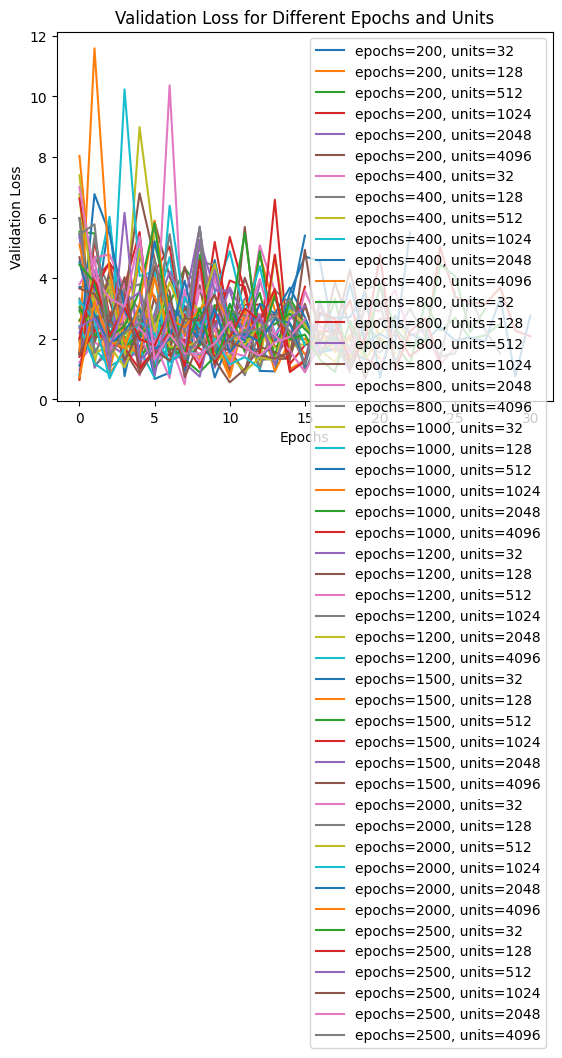

In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import shutil
import os

# Define the feature engineering function
def feature_engineering(df):
    df['排位體重'] = pd.to_numeric(df['排位體重'], errors='coerce')
    df['實際負磅'] = pd.to_numeric(df['實際負磅'], errors='coerce')
    df['average_speed'] = df['距離'] / df['完成時間_秒']
    df['total_weight'] = df['排位體重'] + df['實際負磅']
    return df

# Load data (replace with actual file paths)
# horse_data_filtered = pd.read_excel('/path/to/horse_data_filtered.xlsx')
# horse_data = pd.read_excel('/path/to/horse_data.xlsx')

# Sample data loading (comment out in actual usage)
# horse_data_filtered = pd.read_csv('/path/to/horse_data_filtered.csv')
# horse_data = pd.read_csv('/path/to/horse_data.csv')

# Sample merge (comment out in actual usage)
# merged_data = pd.merge(horse_data, horse_data_filtered, left_on='date', right_on='date', how='left')

# Apply feature engineering
# df = feature_engineering(merged_data)

# Handle missing values
# df = df.dropna()

# Define features and target
# features = df[['average_speed', 'total_weight', '檔位', '騎師_0', '騎師_1', ...]]
# target = df['名次']

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define model building function
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=1024, step=32), input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units_4', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units_5', min_value=32, max_value=64, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_5', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1]))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Clean up the directory if there were previous runs
tuner_directory = 'my_dir/intro_to_kt'
if os.path.exists(tuner_directory):
    shutil.rmtree(tuner_directory)

# Define function to run experiments
def run_experiment(epochs, units):
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='my_dir',
        project_name='intro_to_kt'
    )

    tuner.search(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])
    best_model = tuner.get_best_models(num_models=1)[0]
    history = best_model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    loss, mae = best_model.evaluate(X_test, y_test)
    return loss, mae, history

# Define different settings for experiments
epochs_list = [200, 400, 800,1000,1200,1500,2000,2500]
units_list = [32, 128, 512,1024,2048,4096]

results = []
for epochs in epochs_list:
    for units in units_list:
        loss, mae, history = run_experiment(epochs, units)
        results.append((epochs, units, loss, mae, history))

# Plot results
for result in results:
    epochs, units, loss, mae, history = result
    plt.plot(history.history['val_loss'], label=f'epochs={epochs}, units={units}')

plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss for Different Epochs and Units')
plt.show()
